In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.style.use('ggplot')

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

passenger_ids = test_data['PassengerId']

In [4]:
train_data.head() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# The categorical columns that need to be encoded
train_data.select_dtypes(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,NaN,S
887,"Graham, Miss. Margaret Edith",female,112053,B42,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S
889,"Behr, Mr. Karl Howell",male,111369,C148,C


# Handling missing values and creating synthetic featuers

In [6]:
# Columns that have missing values
pd.concat([train_data, test_data]).isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [7]:
def get_deck(cabin):
    deck_search = re.search('[A-Za-z]', cabin)
    if deck_search:
        return deck_search.group(0)
    return ""

train_data["Cabin"] = train_data["Cabin"].fillna("")
train_data['CabinDeck'] = train_data['Cabin'].apply(get_deck)
train_data["CabinDeckCode"] = train_data["CabinDeck"]
train_data["CabinDeck"] = train_data["CabinDeck"].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})
train_data = train_data.drop('Cabin', axis=1)

test_data["Cabin"] = test_data["Cabin"].fillna("")
test_data['CabinDeck'] = test_data['Cabin'].apply(get_deck)
test_data["CabinDeckCode"] = test_data["CabinDeck"]
test_data["CabinDeck"] = test_data["CabinDeck"].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})
test_data = test_data.drop('Cabin', axis=1)

In [8]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')
test_data['Embarked'] = test_data['Embarked'].fillna('S')

# There are a lot of missing values in the Age column. 
# So we will use the IterativeImputer to fill in the missing values,
# instead of just using the median or mean value.
imputer = IterativeImputer(max_iter=10, random_state=0)
cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'CabinDeck']
train_data[cols] = imputer.fit_transform(train_data[cols])
test_data[cols] = imputer.fit_transform(test_data[cols])

In [9]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
CabinDeck        0
CabinDeckCode    0
dtype: int64

In [10]:
train_data["FamilySize"] = train_data["SibSp"] + train_data["Parch"] + 1
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"] + 1

train_data['IsAlone'] = 0
train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1
test_data['IsAlone'] = 0
test_data.loc[test_data['FamilySize'] == 1, 'IsAlone'] = 1

train_data["Title"] = train_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')
train_data['Title'] = train_data['Title'].replace('Ms', 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')
test_data["Title"] = test_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Title'].replace('Mlle', 'Miss')
test_data['Title'] = test_data['Title'].replace('Ms', 'Miss')
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs')

In [11]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinDeck,CabinDeckCode,FamilySize,IsAlone,Title
0,1,0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,S,6.408382,,2.0,0,Mr
1,2,1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C,3.000000,C,2.0,0,Mrs
2,3,1,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,S,6.121712,,1.0,1,Miss
3,4,1,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,S,3.000000,C,2.0,0,Mrs
4,5,0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,S,6.099914,,1.0,1,Mr


# Visualizing

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

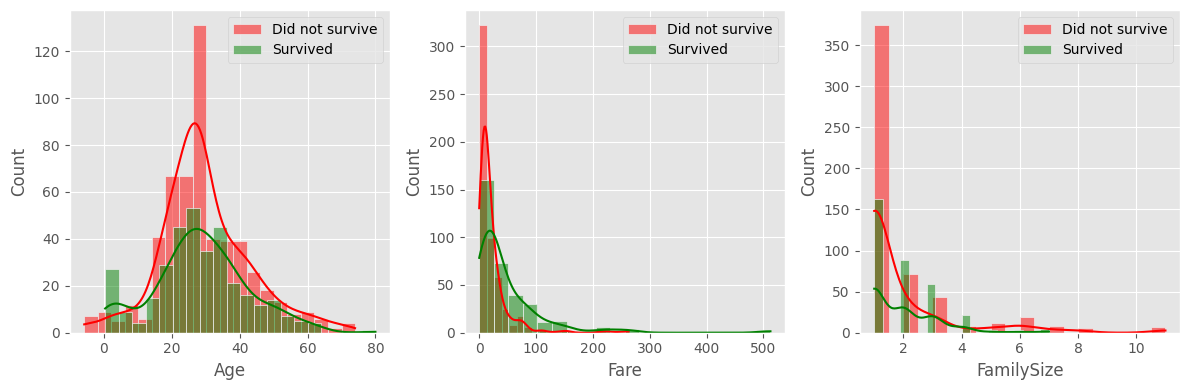

In [12]:
survivors = train_data[train_data['Survived'] == 1]
non_survivors = train_data[train_data['Survived'] == 0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, column_name in enumerate(["Age", "Fare", "FamilySize"]):
    sns.histplot(non_survivors[column_name], bins=20, color='red', label='Did not survive', ax=ax[i], kde=True)
    sns.histplot(survivors[column_name], bins=20, color='green', label='Survived', ax=ax[i], kde=True)
    ax[i].set_xlabel(column_name)
    ax[i].set_ylabel('Count')
    ax[i].legend()

plt.tight_layout()
plt.show()

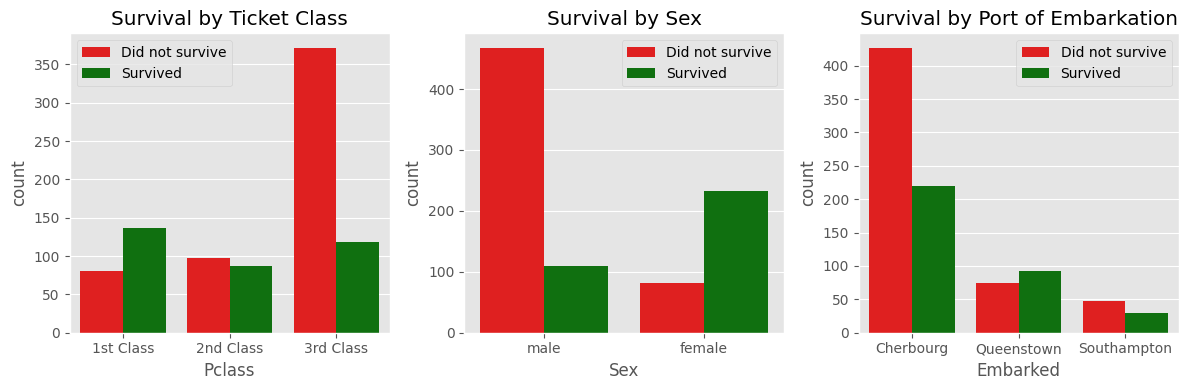

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.countplot(x='Pclass', hue='Survived', data=train_data, palette={0: 'red', 1: 'green'}, ax=ax[0])
ax[0].set_title('Survival by Ticket Class')
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['1st Class', '2nd Class', '3rd Class'])
ax[0].legend(labels=["Did not survive", "Survived"])

sns.countplot(x='Sex', hue='Survived', data=train_data, palette={0: 'red', 1: 'green'}, ax=ax[1])
ax[1].set_title('Survival by Sex')
ax[1].legend(labels=["Did not survive", "Survived"])

sns.countplot(x='Embarked', hue='Survived', data=train_data, palette={0: 'red', 1: 'green'}, ax=ax[2])
ax[2].set_title('Survival by Port of Embarkation')
ax[2].set_xticks([0, 1, 2])
ax[2].set_xticklabels(["Cherbourg", "Queenstown", "Southampton"])
ax[2].legend(labels=["Did not survive", "Survived"])

plt.tight_layout()
plt.show()

In [14]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

train_data['Title'] = train_data['Title'].map(title_mapping)
train_data['Sex'] = train_data['Sex'].map({'female': 0, 'male': 1})
train_data['Embarked'] = train_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )

test_data['Title'] = test_data['Title'].map(title_mapping)
test_data['Sex'] = test_data['Sex'].map({'female': 0, 'male': 1})
test_data['Embarked'] = test_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )

In [15]:
train_data.loc[train_data['Fare'] <= 7.91, 'Fare'] = 0
train_data.loc[(train_data['Fare'] > 7.91) & (
    train_data['Fare'] <= 14.454), 'Fare'] = 1
train_data.loc[(train_data['Fare'] > 14.454) & (
    train_data['Fare'] <= 31), 'Fare'] = 2
train_data.loc[train_data['Fare'] > 31, 'Fare'] = 3

test_data.loc[test_data['Fare'] <= 7.91, 'Fare'] = 0
test_data.loc[(test_data['Fare'] > 7.91) & (
    test_data['Fare'] <= 14.454), 'Fare'] = 1
test_data.loc[(test_data['Fare'] > 14.454) & (
    test_data['Fare'] <= 31), 'Fare'] = 2
test_data.loc[test_data['Fare'] > 31, 'Fare'] = 3

In [16]:
train_data.loc[train_data['Age'] <= 16, 'Age'] = 0
train_data.loc[(train_data['Age'] > 16) & (train_data['Age'] <= 32), 'Age'] = 1
train_data.loc[(train_data['Age'] > 32) & (train_data['Age'] <= 48), 'Age'] = 2
train_data.loc[(train_data['Age'] > 48) & (train_data['Age'] <= 64), 'Age'] = 3
train_data.loc[train_data['Age'] > 64, 'Age'] = 4

test_data.loc[test_data['Age'] <= 16, 'Age'] = 0
test_data.loc[(test_data['Age'] > 16) & (test_data['Age'] <= 32), 'Age'] = 1
test_data.loc[(test_data['Age'] > 32) & (test_data['Age'] <= 48), 'Age'] = 2
test_data.loc[(test_data['Age'] > 48) & (test_data['Age'] <= 64), 'Age'] = 3
test_data.loc[test_data['Age'] > 64, 'Age'] = 4

In [17]:
train_data = train_data.ffill()
test_data = test_data.ffill()
# types = {
#     "Pclass": "int",
#     "Sex": "int",
#     "Age": "int",
#     "SibSp": "int",
#     "Parch": "int",
#     "Fare": "int",
#     "Embarked": "int",
#     "CabinDeck": "int",
#     "FamilySize": "int",
#     "IsAlone": "int",
#     "Title": "int"
# }
# train_data = train_data.astype(types)
# test_data = test_data.astype(types)

In [18]:
train_data = train_data.drop(['Name', 'Ticket', 'PassengerId', 'CabinDeckCode'], axis=1)
test_data = test_data.drop(['Name', 'Ticket', 'PassengerId', 'CabinDeckCode'], axis=1)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinDeck,FamilySize,IsAlone,Title
0,0,3.0,1,1.0,1.0,0.0,0.0,0,6.408382,2.0,0,1.0
1,1,1.0,0,2.0,1.0,0.0,3.0,1,3.000000,2.0,0,3.0
2,1,3.0,0,1.0,0.0,0.0,1.0,0,6.121712,1.0,1,2.0
3,1,1.0,0,2.0,1.0,0.0,3.0,0,3.000000,2.0,0,3.0
4,0,3.0,1,2.0,0.0,0.0,1.0,0,6.099914,1.0,1,1.0


In [19]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

In [20]:
y_train = train_data["Survived"]
X_train = train_data.drop(["Survived"], axis=1)

# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# y_train = y_train.to_numpy()

# X_test = scaler.fit_transform(test_data)
X_test = test_data

In [21]:
X_train.shape, X_test.shape

((891, 11), (418, 11))

In [22]:
model = SVC()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [23]:
submission = pd.DataFrame(passenger_ids, columns=["PassengerId"])
submission["Survived"] = predictions
submission.to_csv("submission.csv", index=False)